# Known concepts in the mechanism


Neurons:

1. Excitory neurons make up about 80% of the total neuronal population.
2. Inhibitory neurons make up about 20% of the total neuronal population. 
3. PV neurons (58% inhibitory) are fast-spiking.
4. SST neurons (42% inhibitory)  are low-threshold spiking. 
5. PC neurons (excitatory) are regular spiking.

Synaptic Connectivities: 

6. PC are highly interconnected (25% to 36% of connectivity probabilities). 
7. SST and PV cells connect to at least half, or even all excitatory cells of the local circuit (> 50% ).
8. Strong inhibition between SST and PC. 
9. PV has recurrent connections. 

Thalamacortical connections: 

10. Strong connections to PV. (Short-term depression)
11. weak connections to SST. (Short-term facilitation)
12. Constant strength to PC. 

# Simulation in Brian2

Importing the Brian package and setting up matplotlib for IPython:

In [1]:
from brian2 import *
from DynapSE import DynapSE

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

# Display plots inside Jupyter cell
%matplotlib inline 
# Set the dots-per-inch (resolution) of the images
mpl.rcParams['figure.dpi'] = 90

from equations.dynapse_eq import *
from parameters.dynapse_param import *

# C++ code generation for faster spiking network simulation
set_device('cpp_standalone')
# Ignore Brian2 base warnings
BrianLogger.suppress_name('base')
# The clock of Brian2 simulation for numerically solve ODEs
defaultclock.dt = 20 * us

# Spike-Frequency Adaptation -> Single Neuron

Controlling a balanced spike-frequency adaptation at a singular neuron level. We need to calibrate the parameters: 
$I_{tauahp}$ and $I_{thahp}$. These currents usually operate in the $10^{-2}$ pA. 

In [4]:
device.reinit()
device.activate()
defaultclock.dt = 20 * us

## Observing Adaptation Effect
##################
# Tune Itauahp and Ithahp currents to observe a spike-frequency adaptation

# Parameters
inp_duration = 1     # second - Simulation duration


# Create a Brian2 network and chip instance using that monitors DynapSE resources.
network = Network()
chip = DynapSE(network)

# Connect a single spike generator to a single DPI neuron 
DPI_neuron  = chip.get_neurons(1, 'Core_1')


# Using paramGen, set adaptation configurations for Core #1
# In DynapSE, parames are set per Core.
# In samna, this command is like: set_param(core_id, param_name, fine_value, coarse_value)


adaptation_conf = {
                   "Iconst" : 500 * pA,
                   "Itau" : 1 * pA,
                   "Ith"  : 30 * pA,                   
                   "Itauahp": 0.1 * pA,                 
                   "Ithahp": 0.2 * pA
                  }


# merge the param dict into 1.
core_conf = {**adaptation_conf}
# set the params
chip.set_bias(core_conf, 'Core_1')

# Monitors
mon_neuron_output = SpikeMonitor(DPI_neuron, name='mon_neuron_output')
mon_adapt_state  = StateMonitor(DPI_neuron,  'Iahp', record=True)
mon_mem_state  = StateMonitor(DPI_neuron,  'Imem', record=True)
network.add([ DPI_neuron, mon_neuron_output,mon_adapt_state,mon_mem_state])

# Simulation
network.run(inp_duration * 1000 * ms)

1 neurons are allocated from Core_1.
New bias values are loaded to Core_1.


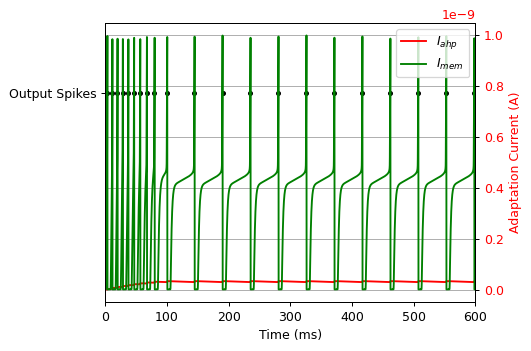

In [5]:
##################
#  TODO: Change tstart and tend to find the time window that shows spike-frequency adaptation.
#
# Parameters
tstart = 0 # ms - 
tend   = 600 # ms -
##################


# Plotting
spike_placeholder2 = np.zeros(inp_duration*1000)
spike_placeholder2[np.array(mon_neuron_output.t/ms, dtype=int)]=3

s = int(1*ms / defaultclock.dt)
fig, ax1 = plt.subplots()

ax1.set_xlabel('Time (ms)')
plt.yticks(np.arange(1,4,2), ['d','Output Spikes'])
ax1.tick_params(axis='y')
plt.ylim(1.5, 3.5)
plt.xlim(tstart,tend)
ax2 = ax1.twinx()  
ax1.plot(spike_placeholder2,'k.')

ax2.set_ylabel('Adaptation Current (A)', color='r')  
ax2.plot(mon_adapt_state.t/ms, mon_adapt_state.Iahp[0], linewidth=1.5,color='r')
ax2.tick_params(axis='y', labelcolor='r')
plt.xlim(tstart,tend)


fig.tight_layout()
plt.grid(True)

ax2.plot(mon_mem_state.t/ms, mon_mem_state.Imem[0], linewidth=1.5, color='g')
plt.legend(['$I_{ahp}$','$I_{mem}$','c'])
plt.show()

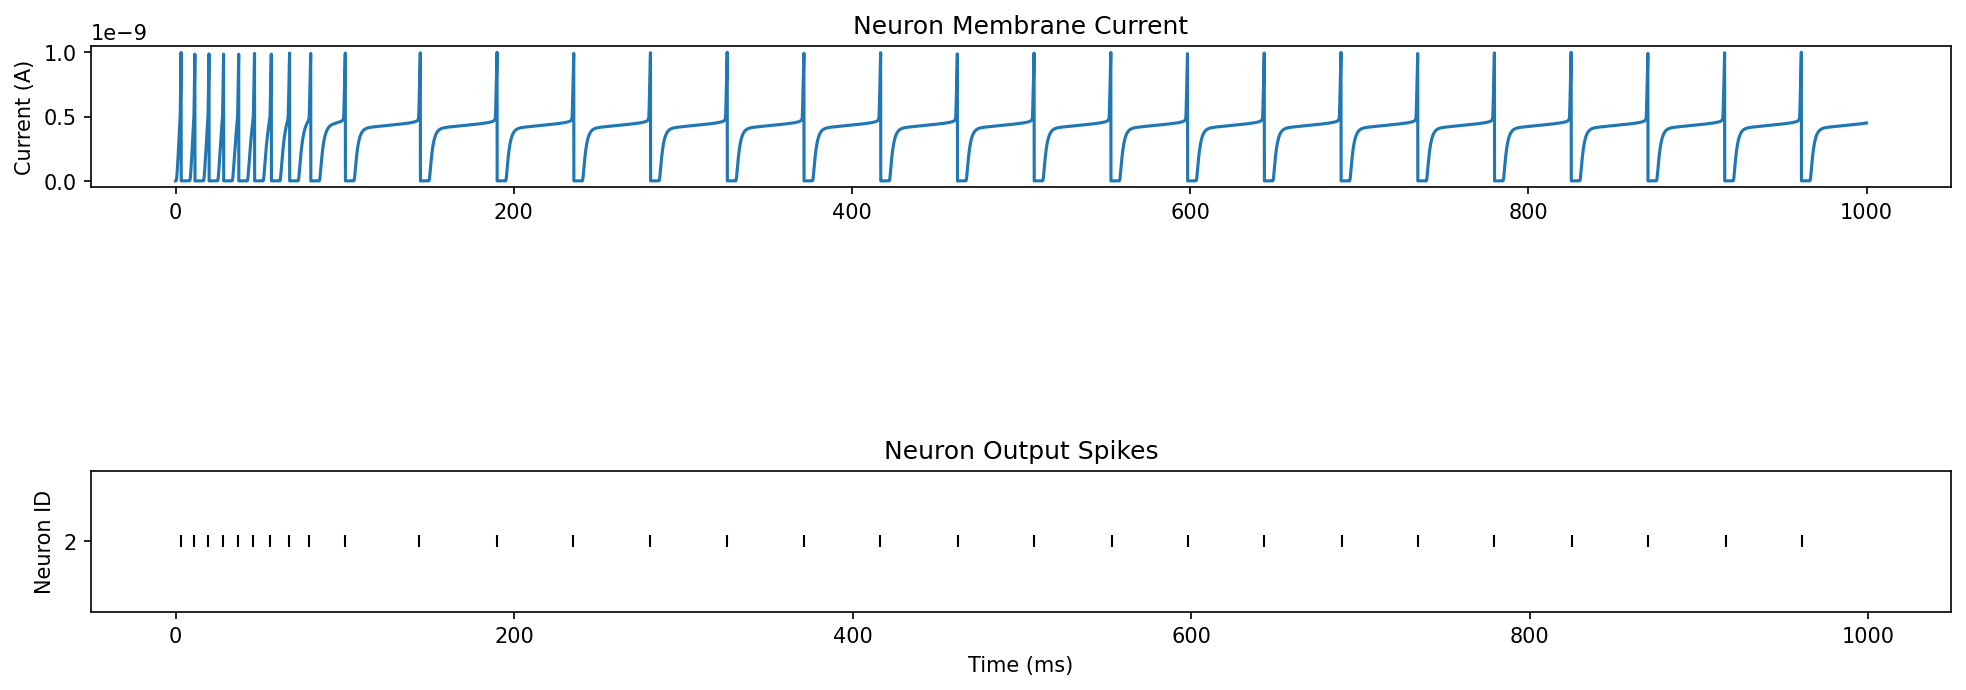

In [4]:
# plotting
plt.figure(figsize=(16,5),dpi=150)
plt.subplots_adjust(hspace=2)

times = int(inp_duration/ms)


plt.subplot(211)
Imem = mon_mem_state.Imem[0]
plt.plot(mon_mem_state.t/ms, Imem)

plt.title('Neuron Membrane Current')
plt.ylabel('Current (A)')
#plt.xlabel('Time (ms)')

plt.subplot(212)
spike_placeholder = np.zeros(times)
spike_placeholder[np.array(mon_neuron_output.t/ms, dtype=int)]=2
plt.plot(spike_placeholder,'k|')
matplotlib.pyplot.yticks(range(1, 3))
plt.ylim(1.5, 2.5)
plt.title('Neuron Output Spikes')
plt.ylabel('Neuron ID')
plt.xlabel('Time (ms)')
plt.show()

Make sure that we are in a biologically plausible range for the temporal dynamics: 
1. Neuron Leak time constant $[10-100] ms$
1. Calcium Leak time constant $[50-400] ms$


In [6]:
print('time constant of Iahp', DPI_neuron.tauahp[0])
print('time constant of Imem', DPI_neuron.tau[0])

time constant of Iahp 0.35460993 s
time constant of Imem 53.19148936 ms


# Regular Spiking -> Gain of $\frac{1}{10}$  

The proper way to obtain our desired gain is to tune the synaptic and neuron time constants, and also the synaptic weights. More precisely, if we have an input frequency of 100 Hz, we want a synaptic time constant of $\tau_{syn} = 10 ms$. As a result, for a gain of $\frac{1}{10}$, the output frequency must be 10 Hz. Therefore, we want a neuron time constant of $\tau_{mem} = 100 ms $. From this, we know that we have to properly tune $I_{syn,tau}$ and $I_{mem,tau}$

In [9]:
device.reinit()
device.activate()
defaultclock.dt = 20 * us

# Parameters
pulse_start  = 0     # second - Start timing of pulse
pulse_stop   = 1     # second - Stop timing of pulse
inp_duration = 1     # second - Simulation duration
firing_rate  = 100  # Hz - Firing rate of the source

# Create a regular spiking pattern
spikes = np.zeros(inp_duration*1000)
dt = int(1000/firing_rate)
spikes[pulse_start*1000:pulse_stop*1000:dt] = 1.0
spike_timing = np.where(spikes==1)[0] * ms
neuron_indices = np.zeros(len(spike_timing))
input_spike_generator = SpikeGeneratorGroup(1, indices=neuron_indices, times=spike_timing, name='InpSpikeGenerator')    
#input_spike_generator = PoissonGroup(1, firing_rate * Hz)

# Create a Brian2 network and chip instance using that monitors DynapSE resources.
network = Network()
chip = DynapSE(network)

# Connect a single spike generator to a single DPI neuron 
DPI_neuron  = chip.get_neurons(1, 'Core_1')
DPI_synapse = chip.add_connection(input_spike_generator, DPI_neuron, synapse_type='AMPA')
chip.connect(DPI_synapse, True)
DPI_synapse.weight = 1
DPI_synapse.d = 0


# Using paramGen, set adaptation configurations for Core #1
# In DynapSE, parames are set per Core.
# In samna, this command is like: set_param(core_id, param_name, fine_value, coarse_value)
ampa_conf = {"I_tau_syn_ampa": 5 * pA,
            "I_g_syn_ampa": 5 * pA,
            "I_wo_syn_ampa": 300 * pA
            }

adaptation_conf = {
                   "Itau" : 0.5 * pA,
                   "Ith"  : 2.5 * pA,
                   "Ica"  : 0 * pA
                  }


# merge the param dict into 1.
core_conf = {**ampa_conf,**adaptation_conf}
# set the params
chip.set_bias(core_conf, 'Core_1')

# Monitors
mon_dep_state = StateMonitor(DPI_neuron,  'D', record=True)
mon_neuron_input  = SpikeMonitor(input_spike_generator, name='mon_neuron_input')
mon_neuron_output = SpikeMonitor(DPI_neuron, name='mon_neuron_output')
mon_synapse_ampa  = StateMonitor(DPI_synapse, 'I_syn_ampa', record=[0])
mon_adapt_state  = StateMonitor(DPI_neuron,  'Iahp', record=True)
mon_mem_state  = StateMonitor(DPI_neuron,  'Imem', record=True)
network.add([input_spike_generator, DPI_neuron, DPI_synapse, mon_neuron_input, mon_neuron_output,mon_synapse_ampa,mon_adapt_state,mon_mem_state,mon_dep_state])

# Simulation
network.run(inp_duration * 1000 * ms)

1 neurons are allocated from Core_1.
New bias values are loaded to Core_1.


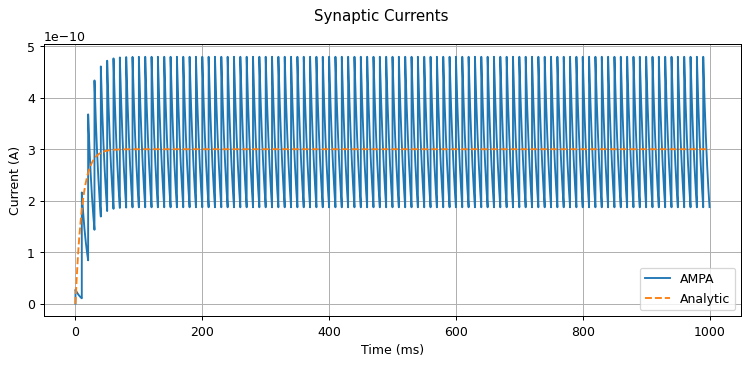

In [10]:
##################
#  TODO: Play with tstart and tend to locate synaptic currents. Try to estimate the time constant of the decay. 
#
# Parameters
tstart = 0 # ms 
tend   = 1000 # ms
##################

# Plotting
fig, ax1 = plt.subplots(figsize=(10,4))
fig.suptitle('Synaptic Currents')
s = int(1*ms / defaultclock.dt)

ax1.plot(mon_mem_state.t[tstart*s:tend*s]/ms, mon_synapse_ampa.I_syn_ampa[0][tstart*s:tend*s], linewidth=1.5, label='AMPA')
ax1.plot(mon_mem_state.t[tstart*s:tend*s]/ms, DPI_synapse.I_wo_syn_ampa*(1-exp(-mon_mem_state.t/DPI_synapse.tau_syn_exc2[0]))[tstart*s:tend*s], 'C1--',label='Analytic')
ax1.legend()
ax1.set_ylabel('Current (A)')
ax1.set_xlabel('Time (ms)')
ax1.grid(True)

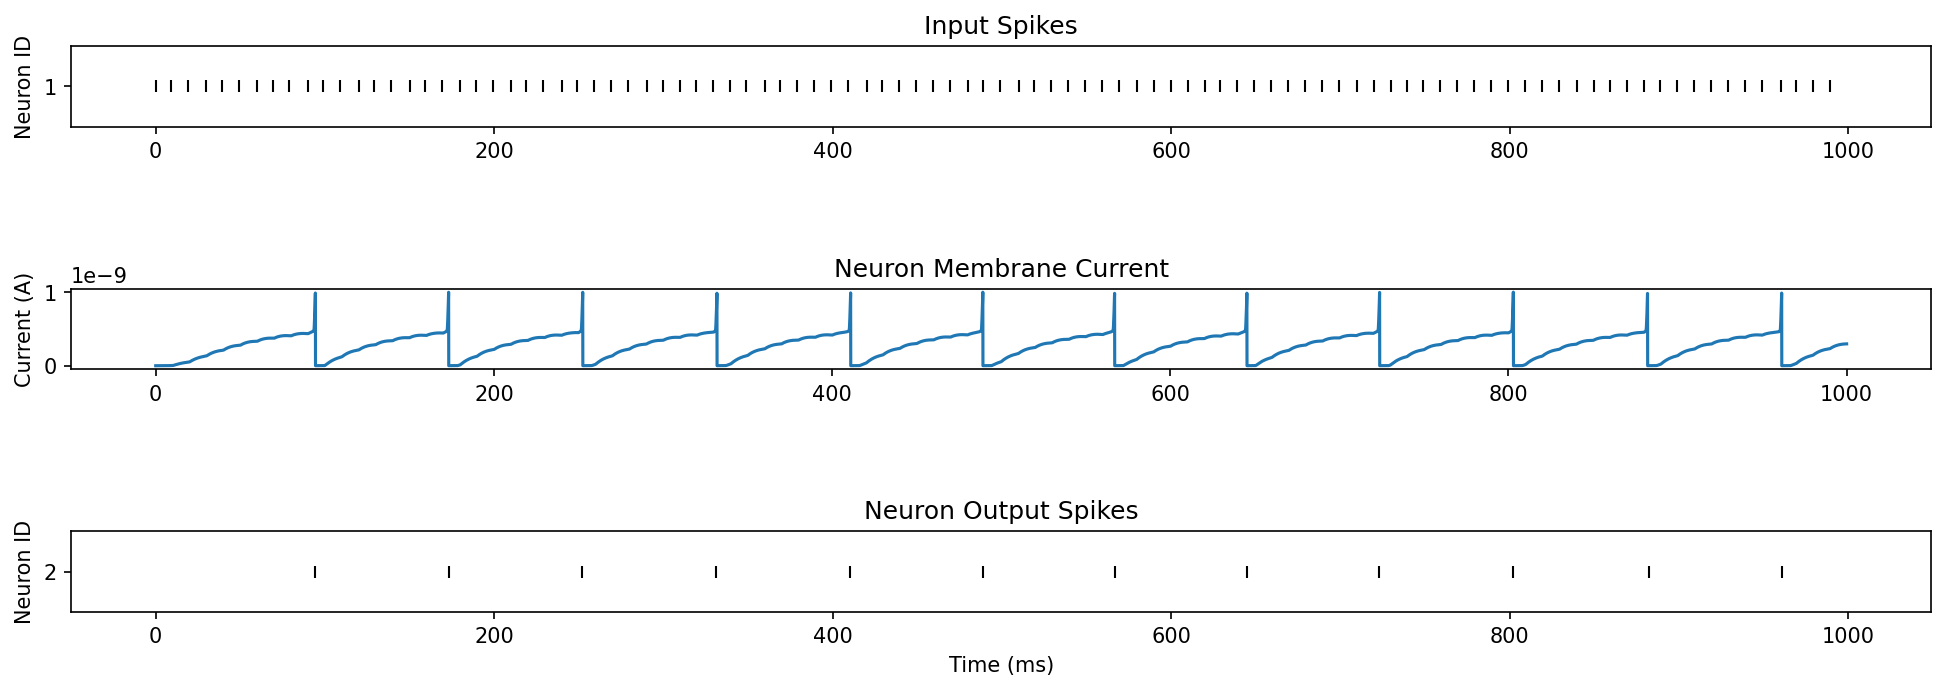

In [11]:
# plotting
plt.figure(figsize=(16,5),dpi=150)
plt.subplots_adjust(hspace=2)

times = int(inp_duration/ms)

# Input Spikes 
plt.subplot(311)
spike_placeholder = np.zeros(times)
spike_placeholder[np.array(mon_neuron_input.t/ms, dtype=int)]=1
plt.plot(spike_placeholder,'k|')
matplotlib.pyplot.yticks(range(1, 3))
plt.ylim(0.5, 1.5)
plt.title('Input Spikes')
plt.ylabel('Neuron ID')
#plt.xlabel('Time (ms)')

plt.subplot(312)
Imem = mon_mem_state.Imem[0]
plt.plot(mon_mem_state.t/ms, Imem)

plt.title('Neuron Membrane Current')
plt.ylabel('Current (A)')
#plt.xlabel('Time (ms)')

plt.subplot(313)
spike_placeholder = np.zeros(times)
spike_placeholder[np.array(mon_neuron_output.t/ms, dtype=int)]=2
plt.plot(spike_placeholder,'k|')
matplotlib.pyplot.yticks(range(1, 3))
plt.ylim(1.5, 2.5)
plt.title('Neuron Output Spikes')
plt.ylabel('Neuron ID')
plt.xlabel('Time (ms)')
plt.show()

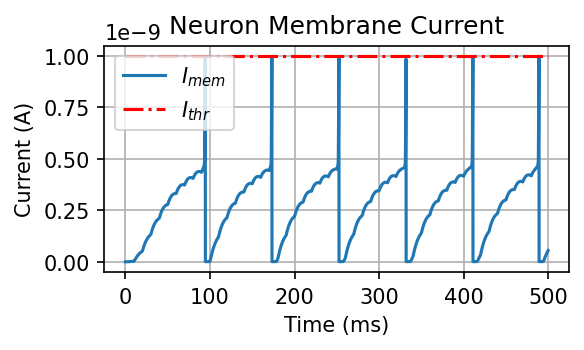

In [12]:
##################
#  TODO: Play with tstart and tend to observe membrane current fluctuations and the moments of spike output.
#        Notice that the membrane current is more smoother than its synaptic input.
#
# Parameters
tstart = 0 # ms  
tend   = 500 # ms 
##################

# Plotting
s = int(1*ms / defaultclock.dt)
plt.figure(figsize=(4,2),dpi=150)
plt.plot(mon_mem_state.t[tstart*s:tend*s]/ms, mon_mem_state.Imem[0][tstart*s:tend*s], linewidth=1.5)
plt.hlines(y=dynapse_param['Ispkthr']*1e-9/nA, xmin=tstart, xmax=tend, color='r', linestyles='-.')
plt.legend(['$I_{mem}$', '$I_{thr}$'])
plt.title('Neuron Membrane Current')
plt.ylabel('Current (A)')
plt.xlabel('Time (ms)')
plt.grid(True)

Make sure we observe a gain of $\frac{1}{10}$

In [13]:
print('time constant of Isyn', DPI_synapse.tau_syn_exc2[0])
print('time constant of Imem', DPI_neuron.tau[0])
print('leak time constant of Imem', DPI_neuron.tauahp[0])
print('Input firing rate = ', mon_neuron_input.count/ (inp_duration* 1000 * ms))
print('Output firing rate = ', mon_neuron_output.count/ (inp_duration* 1000 * ms))
print('number of input spikes',mon_neuron_input.count[0])
print('number of output spikes',mon_neuron_output.count[0])

time constant of Isyn 10.63829787 ms
time constant of Imem 106.38297872 ms
leak time constant of Imem 70.92198582 ms
Input firing rate =  [100.] Hz
Output firing rate =  [12.] Hz
number of input spikes 100
number of output spikes 12


# Short-Term Facilitation

Controlling Short-Term Facilitation at a synapse level without spike frequency adaptation. 

![dpi/synapse.png](img/synapse.png)

This is the DPI synapse circuit. Only the yellow block, responsible for the temporal dynamics of DPI circuit, is present in the INI Neuromorphic chip Labs. 
Short-term facilitation can be obtained if the bias $V_{thr}$ of $MD1$ is set that $I_{thr} \gg I_{syn}$ at the onset of stimulation (during the first stimulations). The change in circuit response increases with every spike, by an amount greater than one, for as long as the condition $I_{thr} \gg I_{syn}$ is satisfied. 

In [14]:
device.reinit()
device.activate()
defaultclock.dt = 20 * us

# Parameters
pulse_start  = 0     # second - Start timing of pulse 
pulse_stop   = 1     # second - Stop timing of pulse
inp_duration = 1     # second - Simulation duration
firing_rate  = 100  # Hz - Firing rate of the source

# Create a regular spiking pattern
spikes = np.zeros(inp_duration*1000)
dt = int(1000/firing_rate)
spikes[pulse_start*1000:pulse_stop*1000:dt] = 1.0
spike_timing = np.where(spikes==1)[0] * ms
neuron_indices = np.zeros(len(spike_timing))
input_spike_generator = SpikeGeneratorGroup(1, indices=neuron_indices, times=spike_timing, name='InpSpikeGenerator')    
#input_spike_generator = PoissonGroup(1, firing_rate * Hz)

# Create a Brian2 network and chip instance using that monitors DynapSE resources.
network = Network()
chip = DynapSE(network)

# Connect a single spike generator to a single DPI neuron 
DPI_neuron  = chip.get_neurons(1, 'Core_1')
DPI_synapse = chip.add_connection(input_spike_generator, DPI_neuron, synapse_type='AMPA')
chip.connect(DPI_synapse, True)
DPI_synapse.weight = 1
DPI_synapse.d = 0


# Using paramGen, set adaptation configurations for Core #1
# In DynapSE, parames are set per Core.
# In samna, this command is like: set_param(core_id, param_name, fine_value, coarse_value)
ampa_conf = {"I_tau_syn_ampa": 5 * pA,
            "I_g_syn_ampa": 1000 * pA,
            "I_wo_syn_ampa": 10 * pA}

adaptation_conf = {
                   "Itau" : 0.5 * pA,
                   "Ith"  : 2.5 * pA,
                   "Ica"  : 0 * pA
                  }


# merge the param dict into 1.
core_conf = {**ampa_conf,**adaptation_conf}
# set the params
chip.set_bias(core_conf, 'Core_1')

# Monitors
mon_neuron_input  = SpikeMonitor(input_spike_generator, name='mon_neuron_input')
mon_neuron_output = SpikeMonitor(DPI_neuron, name='mon_neuron_output')
mon_synapse_ampa  = StateMonitor(DPI_synapse, 'I_syn_ampa', record=[0])
mon_adapt_state  = StateMonitor(DPI_neuron,  'Iahp', record=True)
mon_mem_state  = StateMonitor(DPI_neuron,  'Imem', record=True)
network.add([input_spike_generator, DPI_neuron, DPI_synapse, mon_neuron_input, mon_neuron_output,mon_synapse_ampa,mon_adapt_state,mon_mem_state])

# Simulation
network.run(inp_duration * 1000 * ms)

1 neurons are allocated from Core_1.


WARNING    'Imem' is an internal variable of group 'Core_0', but also exists in the run namespace with the value array([0.00000000e+00, 9.40000000e-05, 2.75187732e-03, ...,
       2.96779159e+02, 2.96787899e+02, 2.96796305e+02]) * pamp. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    'Imem' is an internal variable of group 'Core_1', but also exists in the run namespace with the value array([0.00000000e+00, 9.40000000e-05, 2.75187732e-03, ...,
       2.96779159e+02, 2.96787899e+02, 2.96796305e+02]) * pamp. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    'Imem' is an internal variable of group 'Core_2', but also exists in the run namespace with the value array([0.00000000e+00, 9.40000000e-05, 2.75187732e-03, ...,
       2.96779159e+02, 2.96787899e+02, 2.96796305e+02]) * pamp. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    'I

New bias values are loaded to Core_1.


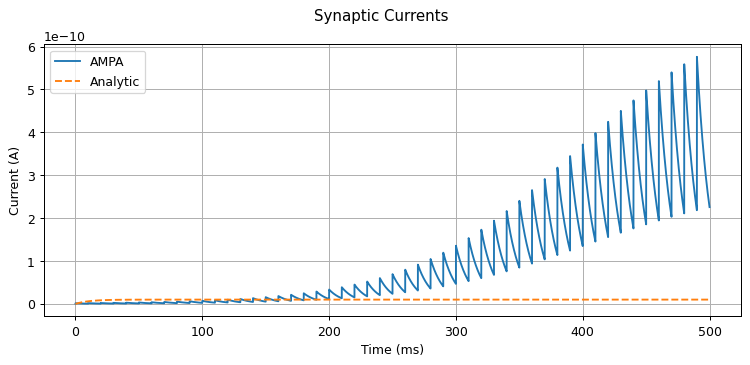

In [15]:
##################
#  TODO: Play with tstart and tend to locate synaptic currents. Try to estimate the time constant of the decay. 
#
# Parameters
tstart = 0 # ms 
tend   = 500 # ms
##################

# Plotting
fig, ax1 = plt.subplots(figsize=(10,4))
fig.suptitle('Synaptic Currents')
s = int(1*ms / defaultclock.dt)

ax1.plot(mon_mem_state.t[tstart*s:tend*s]/ms, mon_synapse_ampa.I_syn_ampa[0][tstart*s:tend*s], linewidth=1.5, label='AMPA')
ax1.plot(mon_mem_state.t[tstart*s:tend*s]/ms, DPI_synapse.I_wo_syn_ampa*(1-exp(-mon_mem_state.t/DPI_synapse.tau_syn_exc2[0]))[tstart*s:tend*s], 'C1--',label='Analytic')
ax1.legend()
ax1.set_ylabel('Current (A)')
ax1.set_xlabel('Time (ms)')
ax1.grid(True)

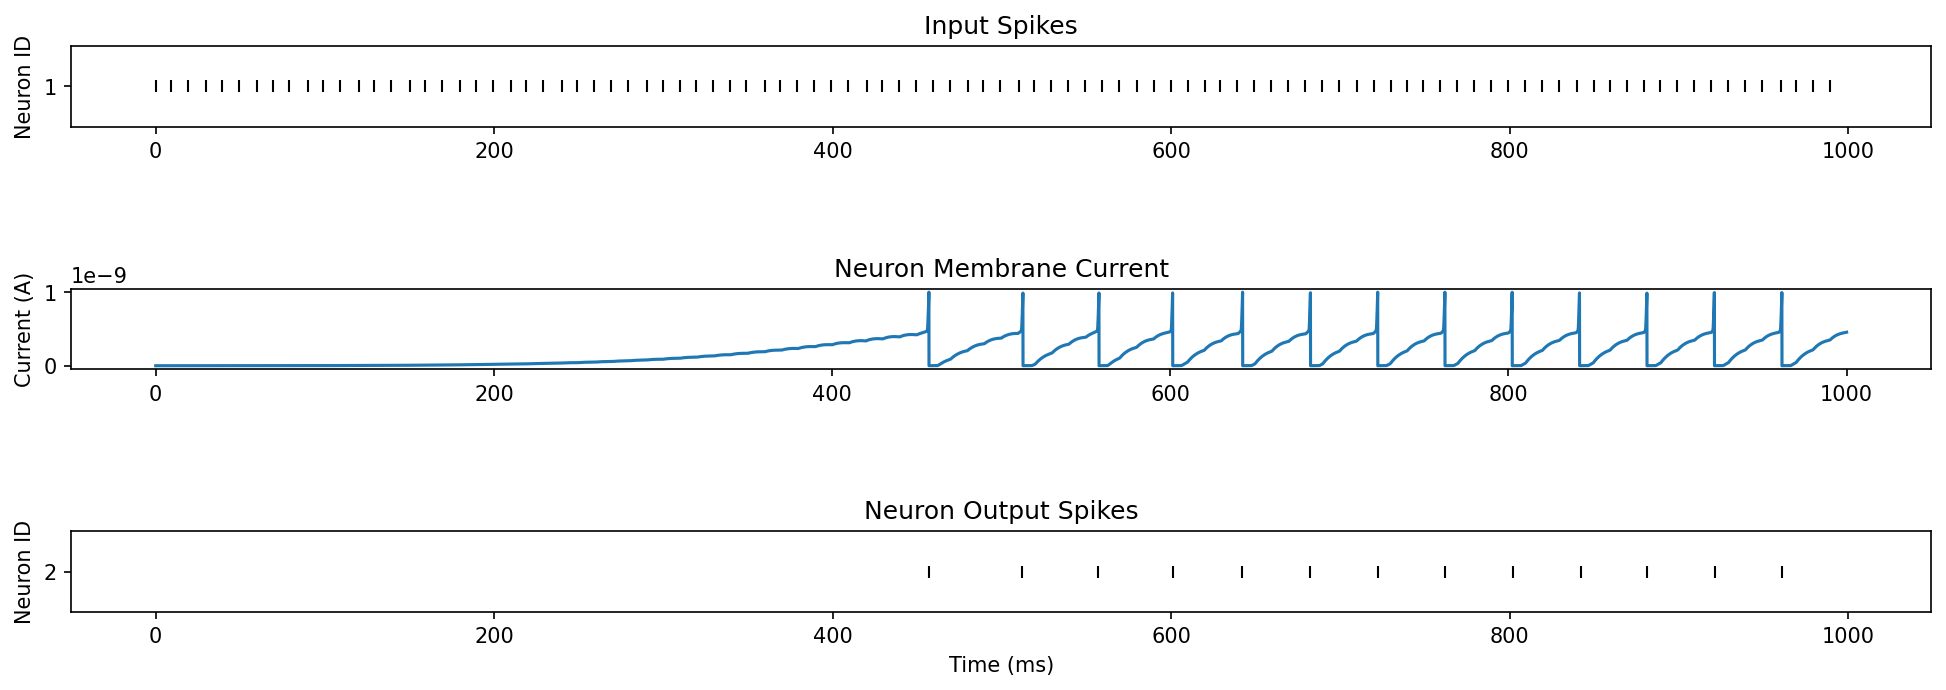

In [16]:
# plotting
plt.figure(figsize=(16,5),dpi=150)
plt.subplots_adjust(hspace=2)

times = int(inp_duration/ms)

# Input Spikes 
plt.subplot(311)
spike_placeholder = np.zeros(times)
spike_placeholder[np.array(mon_neuron_input.t/ms, dtype=int)]=1
plt.plot(spike_placeholder,'k|')
matplotlib.pyplot.yticks(range(1, 3))
plt.ylim(0.5, 1.5)
plt.title('Input Spikes')
plt.ylabel('Neuron ID')
#plt.xlabel('Time (ms)')

plt.subplot(312)
Imem = mon_mem_state.Imem[0]
plt.plot(mon_mem_state.t/ms, Imem)

plt.title('Neuron Membrane Current')
plt.ylabel('Current (A)')
#plt.xlabel('Time (ms)')

plt.subplot(313)
spike_placeholder = np.zeros(times)
spike_placeholder[np.array(mon_neuron_output.t/ms, dtype=int)]=2
plt.plot(spike_placeholder,'k|')
matplotlib.pyplot.yticks(range(1, 3))
plt.ylim(1.5, 2.5)
plt.title('Neuron Output Spikes')
plt.ylabel('Neuron ID')
plt.xlabel('Time (ms)')
plt.show()

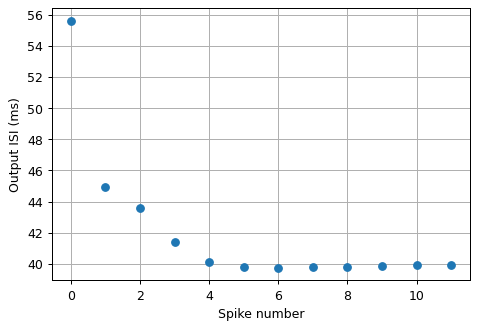

In [17]:
plot(np.diff(mon_neuron_output.t/ms),'o')
plt.ylabel('Output ISI (ms)')
plt.xlabel('Spike number')
plt.grid(True)

# Short-Term Depression

The green block in the DPI synapse circuit is responsible for short-term depression. We need to implement the Synaptic Depression equations from Shih Chii Liu's circuit model in the Dynapse equations.  

$$ \frac{\mathrm{d} D}{\mathrm{d} t} = M (1 - D^{\frac{1}{\kappa}})$$

The update equation at every spike is: 

$$ D(t_{sp}^+) = d D(t_{sp}^-)$$

where $d$ is a value less than 1. From this, the synaptic current gets updated as: 

$$ I_{syn} = g D(t) $$

where g is the synaptic strength. 

In [20]:
device.reinit()
device.activate()
defaultclock.dt = 20 * us

# Parameters
pulse_start  = 0     # second - Start timing of pulse
pulse_stop   = 1     # second - Stop timing of pulse
inp_duration = 1     # second - Simulation duration
firing_rate  = 100  # Hz - Firing rate of the source

# Create a regular spiking pattern
spikes = np.zeros(inp_duration*1000)
dt = int(1000/firing_rate)
spikes[pulse_start*1000:pulse_stop*1000:dt] = 1.0
spike_timing = np.where(spikes==1)[0] * ms
neuron_indices = np.zeros(len(spike_timing))
input_spike_generator = SpikeGeneratorGroup(1, indices=neuron_indices, times=spike_timing, name='InpSpikeGenerator')    
#input_spike_generator = PoissonGroup(1, firing_rate * Hz)

# Create a Brian2 network and chip instance using that monitors DynapSE resources.
network = Network()
chip = DynapSE(network)

# Connect a single spike generator to a single DPI neuron 
DPI_neuron  = chip.get_neurons(1, 'Core_1')
DPI_synapse = chip.add_connection(input_spike_generator, DPI_neuron, synapse_type='AMPA')
chip.connect(DPI_synapse, True)
DPI_synapse.weight = 1
DPI_synapse.d = 0.01 # this tells us the strength of depression 




# Using paramGen, set adaptation configurations for Core #1
# In DynapSE, parames are set per Core.
# In samna, this command is like: set_param(core_id, param_name, fine_value, coarse_value)
ampa_conf = {"I_tau_syn_ampa": 5 * pA,
            "I_g_syn_ampa": 5 * pA,
            "I_wo_syn_ampa": 800 * pA,
            "M" : 0.5 * Hz,
            "D"    : 0,
            }

adaptation_conf = {
                   "Itau" : 0.5 * pA,
                   "Ith"  : 2.5 * pA,
                   "Ica"  : 0 * pA
                  }


# merge the param dict into 1.
core_conf = {**ampa_conf,**adaptation_conf}
# set the params
chip.set_bias(core_conf, 'Core_1')

# Monitors
mon_dep_state = StateMonitor(DPI_neuron,  'D', record=True)
mon_neuron_input  = SpikeMonitor(input_spike_generator, name='mon_neuron_input')
mon_neuron_output = SpikeMonitor(DPI_neuron, name='mon_neuron_output')
mon_synapse_ampa  = StateMonitor(DPI_synapse, 'I_syn_ampa', record=[0])
mon_adapt_state  = StateMonitor(DPI_neuron,  'Iahp', record=True)
mon_mem_state  = StateMonitor(DPI_neuron,  'Imem', record=True)
network.add([input_spike_generator, DPI_neuron, DPI_synapse, mon_neuron_input, mon_neuron_output,mon_synapse_ampa,mon_adapt_state,mon_mem_state,mon_dep_state])

# Simulation
network.run(inp_duration * 1000 * ms)

1 neurons are allocated from Core_1.


WARNING    'Imem' is an internal variable of group 'Core_0', but also exists in the run namespace with the value array([0.00000000e+00, 9.40000000e-05, 2.81961851e-04, ...,
       4.55139979e+02, 4.55242956e+02, 4.55346376e+02]) * pamp. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    'Imem' is an internal variable of group 'Core_1', but also exists in the run namespace with the value array([0.00000000e+00, 9.40000000e-05, 2.81961851e-04, ...,
       4.55139979e+02, 4.55242956e+02, 4.55346376e+02]) * pamp. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    'Imem' is an internal variable of group 'Core_2', but also exists in the run namespace with the value array([0.00000000e+00, 9.40000000e-05, 2.81961851e-04, ...,
       4.55139979e+02, 4.55242956e+02, 4.55346376e+02]) * pamp. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    'I

New bias values are loaded to Core_1.


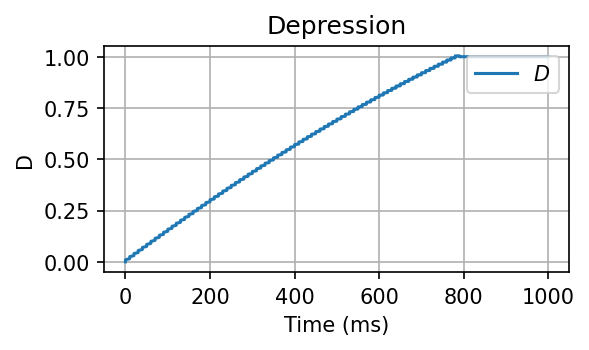

In [22]:
tstart = 0 # ms  
tend   = 1000 # ms 
s = int(1*ms / defaultclock.dt)

D = mon_dep_state.D[0]
plt.figure(figsize=(4,2),dpi=150)
plt.plot(mon_dep_state.t[tstart*s:tend*s]/ms, D[tstart*s:tend*s],linewidth=1.5)
plt.legend(['$D$'],loc='upper right')
plt.title('Depression')
plt.ylabel('D')
plt.xlabel('Time (ms)')
plt.grid(True)

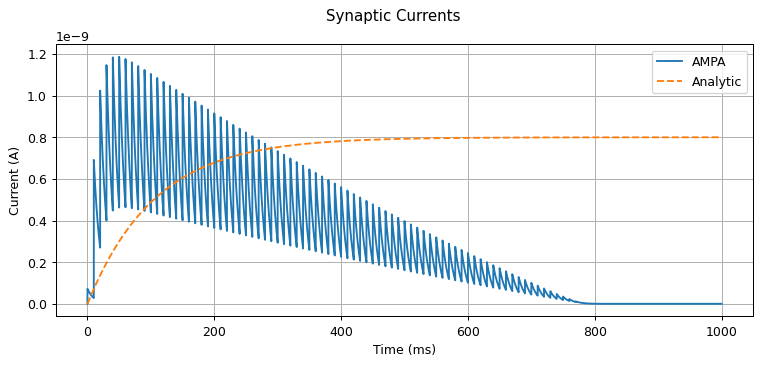

In [26]:
##################
#  TODO: Play with tstart and tend to locate synaptic currents. Try to estimate the time constant of the decay. 
#
# Parameters
tstart = 0 # ms 
tend   = 1000 # ms
##################

# Plotting
fig, ax1 = plt.subplots(figsize=(10,4))
fig.suptitle('Synaptic Currents')
s = int(1*ms / defaultclock.dt)

ax1.plot(mon_mem_state.t[tstart*s:tend*s]/ms, mon_synapse_ampa.I_syn_ampa[0][tstart*s:tend*s], linewidth=1.5, label='AMPA')
ax1.plot(mon_mem_state.t[tstart*s:tend*s]/ms, DPI_synapse.I_wo_syn_ampa*(1-exp(-mon_mem_state.t/DPI_synapse.tau_syn_exc2[0]))[tstart*s:tend*s], 'C1--',label='Analytic')
ax1.legend()
ax1.set_ylabel('Current (A)')
ax1.set_xlabel('Time (ms)')
ax1.grid(True)

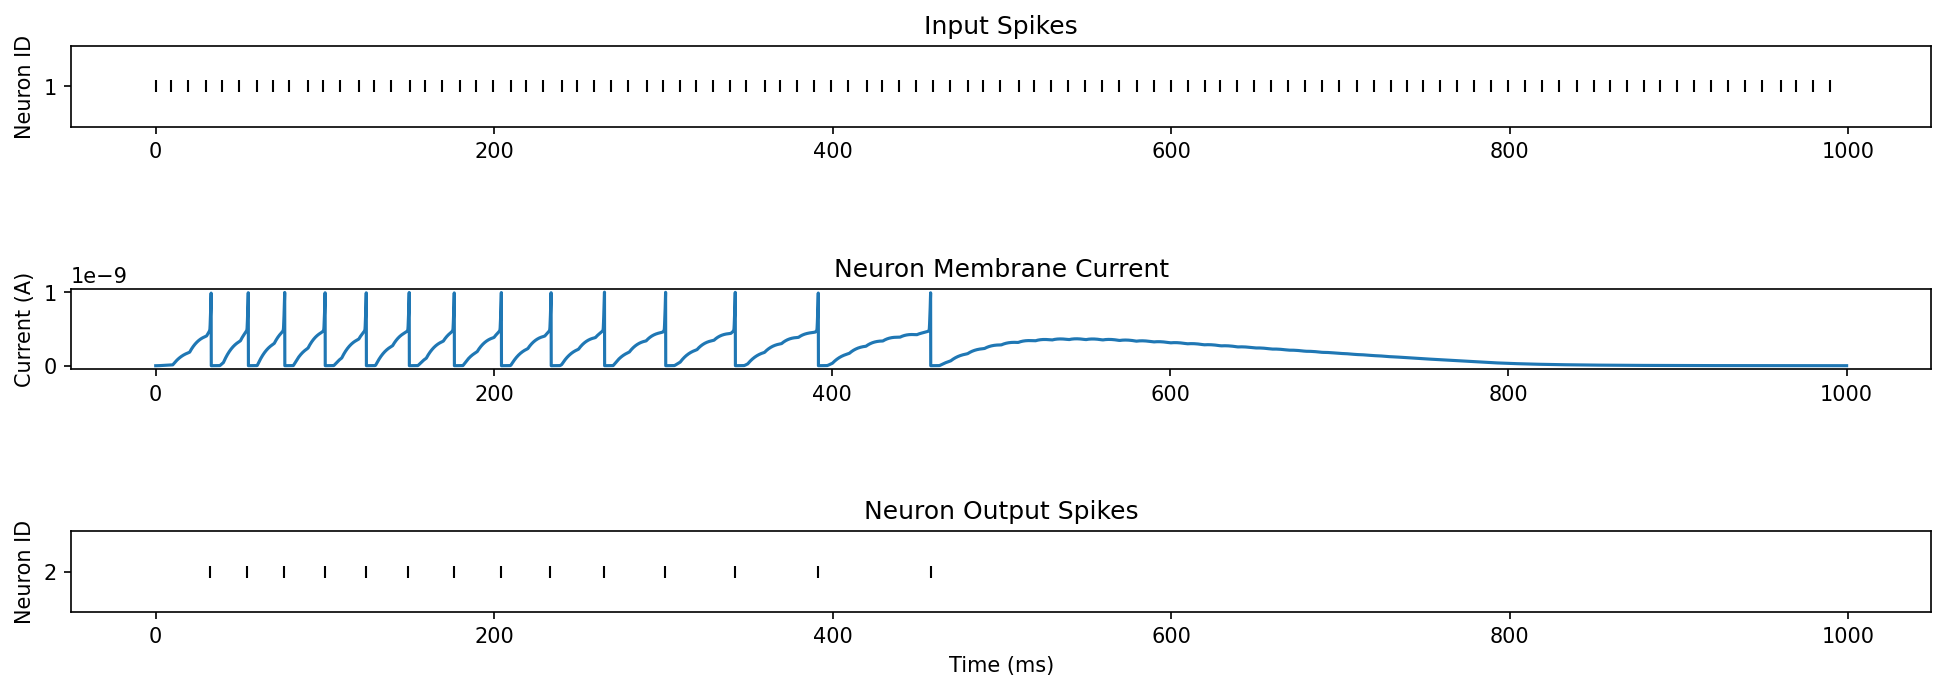

In [24]:
# plotting
plt.figure(figsize=(16,5),dpi=150)
plt.subplots_adjust(hspace=2)

times = int(inp_duration/ms)

# Input Spikes 
plt.subplot(311)
spike_placeholder = np.zeros(times)
spike_placeholder[np.array(mon_neuron_input.t/ms, dtype=int)]=1
plt.plot(spike_placeholder,'k|')
matplotlib.pyplot.yticks(range(1, 3))
plt.ylim(0.5, 1.5)
plt.title('Input Spikes')
plt.ylabel('Neuron ID')
#plt.xlabel('Time (ms)')

plt.subplot(312)
Imem = mon_mem_state.Imem[0]
plt.plot(mon_mem_state.t/ms, Imem)

plt.title('Neuron Membrane Current')
plt.ylabel('Current (A)')
#plt.xlabel('Time (ms)')

plt.subplot(313)
spike_placeholder = np.zeros(times)
spike_placeholder[np.array(mon_neuron_output.t/ms, dtype=int)]=2
plt.plot(spike_placeholder,'k|')
matplotlib.pyplot.yticks(range(1, 3))
plt.ylim(1.5, 2.5)
plt.title('Neuron Output Spikes')
plt.ylabel('Neuron ID')
plt.xlabel('Time (ms)')
plt.show()

In [20]:
print('time constant of Isyn', DPI_synapse.tau_syn_exc2[0])
print('time constant of Imem', DPI_neuron.tau[0])
print('Input firing rate = ', mon_neuron_input.count/ (inp_duration* 1000 * ms))
print('Output firing rate = ', mon_neuron_output.count/ (inp_duration* 1000 * ms))
print('number of input spikes',mon_neuron_input.count[0])
print('number of output spikes',mon_neuron_output.count[0])

time constant of Isyn 106.38297872 ms
time constant of Imem 106.38297872 ms
Input firing rate =  [100.] Hz
Output firing rate =  [14.] Hz
number of input spikes 100
number of output spikes 14


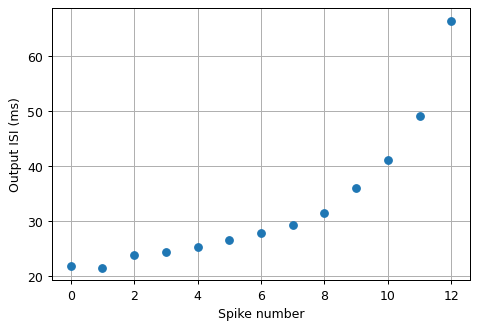

In [21]:
plot(np.diff(mon_neuron_output.t/ms),'o')
plt.ylabel('Output ISI (ms)')
plt.xlabel('Spike number')
plt.grid(True)

# Getting to know the adaptation in the network compartment 

This script is not finilised and it should not be run as problems were encountered with Spike-frequency adaptation for different frequencies. But it can be used as a starting point to investigate adaptation in the network by adding STD and STF. 

In [2]:
# to start a new build to run multiple full simulations
device.reinit()
device.activate()
# need to reset the defaultclock after activate
defaultclock.dt = 20 * us

# Create a Brian2 network and chip instance using that monitors Dynap-SE1 resources.
network = Network()
chip = DynapSE(network)

duration = 10
# number neurons
n = 10
exc = round(n * 0.8)
inh = round(n * 0.2)
n_PC = exc 
n_SST = round(inh * 0.42)
n_PV = round(inh * 0.58)

# define the populations of neurons
PC = chip.get_neurons(n_PC, 'Core_1')
SST = chip.get_neurons(n_SST, 'Core_2')
PV = chip.get_neurons(n_PV, 'Core_3')

# define the input
# frequencies = 5, 50, 500 Hz
rates = 500
spikegen = PoissonGroup(n, rates*Hz)

# Synapses, Thalamacortical Connections
syn_inpPC = chip.add_connection(spikegen, PC, synapse_type='AMPA')
chip.connect(syn_inpPC,True)
syn_inpPV = chip.add_connection(spikegen, PV, synapse_type='AMPA')
chip.connect(syn_inpPV,True)
syn_inpSST = chip.add_connection(spikegen, SST, synapse_type='AMPA')
chip.connect(syn_inpSST,True)

# set Thalamacortical weights
syn_inpPC.weight = 300
syn_inpPV.weight = 600
syn_inpSST.weight = 100

# Synapses, Local Connections
syn_PC = chip.add_connection(PC, PC, synapse_type='NMDA')
syn_PC.connect(p=0.30)
syn_PV = chip.add_connection(PV, PV, synapse_type='GABA_B')
chip.connect(syn_PV,True)

syn_SSTPC = chip.add_connection(SST, PC, synapse_type='GABA_B')
syn_SSTPC.connect(p=0.8)
syn_PVPC = chip.add_connection(PV, PC, synapse_type='GABA_B')
syn_PVPC.connect(p=0.8)

syn_PCSST = chip.add_connection(PV, SST, synapse_type='NMDA')
chip.connect(syn_PCSST,True)
syn_PCPV = chip.add_connection(PC, PV, synapse_type='NMDA')
chip.connect(syn_PCPV,True)

syn_PVSST = chip.add_connection(PV, SST, synapse_type='GABA_B')
chip.connect(syn_PVSST,True)
syn_SSTPV = chip.add_connection(SST, PV, synapse_type='GABA_B')
chip.connect(syn_SSTPV,True)

# set Local connection weights
syn_PC.weight = 300
syn_PV.weight = -300
syn_SSTPC.weight = -600
syn_PVPC.weight = -300
syn_PCSST.weight = 300
syn_PCPV.weight = 300
syn_PVSST.weight = -300
syn_SSTPV.weight = -300

# apply conditions
PV_conf = {"Itau": 50 * pA}
SST_conf = {"Itauahp": 0.03 * pA,            
            "Ithahp": 0.06 * pA,
            "Ispkthr": 0.5 * nA # low threhsold spiking
           }

# set the params
chip.set_bias(PV_conf, 'Core_3')
chip.set_bias(SST_conf, 'Core_2')

# Monitors
mon_neuron_input  = SpikeMonitor(spikegen, name='mon_neuron_input')
mon_neuron_output = SpikeMonitor(SST, name='mon_neuron_output')
mon_adapt_state  = StateMonitor(SST,  'Iahp', record=True)
mon_mem_state  = StateMonitor(SST,  'Imem', record=True)

network.add([spikegen,PC,SST,PV,syn_inpPC,syn_inpPV,syn_inpSST,syn_PC,syn_PV,syn_SSTPC,syn_PVPC,syn_PCSST,syn_PCPV,syn_PVSST,syn_SSTPV,mon_neuron_input,mon_neuron_output,mon_adapt_state,mon_mem_state])

# Simulation
network.run(duration * 1000 * ms)

NameError: name 'device' is not defined

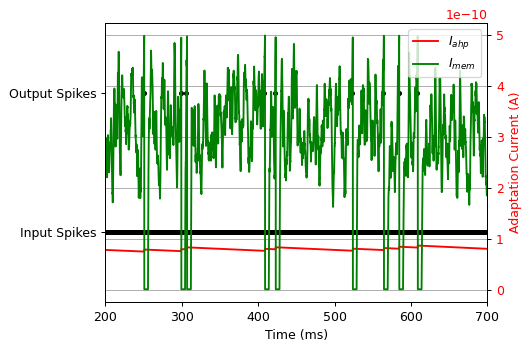

In [28]:
##################
#  TODO: Change tstart and tend to find the time window that shows spike-frequency adaptation.
#
# Parameters
tstart = 200 # ms - 
tend   = 700 # ms -
################## "D" : 0, 


# Plotting
spike_placeholder = np.zeros(duration*1000)
spike_placeholder[np.array(mon_neuron_input.t/ms, dtype=int)]=2

spike_placeholder2 = np.zeros(duration*1000)
spike_placeholder2[np.array(mon_neuron_output.t/ms, dtype=int)]=3

s = int(1*ms / defaultclock.dt)
fig, ax1 = plt.subplots()

ax1.set_xlabel('Time (ms)')
ax1.plot(spike_placeholder,'k.')
plt.yticks(np.arange(1, 5), ['a','Input Spikes','Output Spikes','d'])
ax1.tick_params(axis='y')
plt.ylim(1.5, 3.5)
plt.xlim(tstart,tend)
ax2 = ax1.twinx()  
ax1.plot(spike_placeholder2,'k.')

ax2.set_ylabel('Adaptation Current (A)', color='r')  
ax2.plot(mon_adapt_state.t/ms, mon_adapt_state.Iahp[0], linewidth=1.5,color='r')
ax2.tick_params(axis='y', labelcolor='r')
plt.xlim(tstart,tend)


fig.tight_layout()
plt.grid(True)

ax2.plot(mon_mem_state.t/ms, mon_mem_state.Imem[0], linewidth=1.5, color='g')
plt.legend(['$I_{ahp}$','$I_{mem}$','c'])
plt.show()

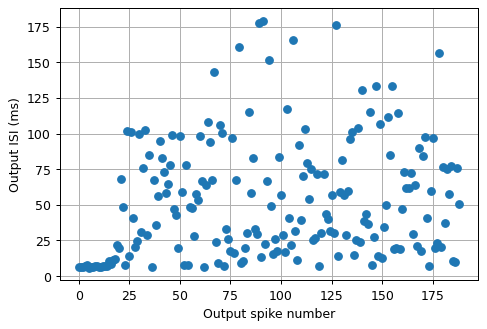

In [29]:
# Plotting output ISI
plot(np.diff(mon_neuron_output.t/ms),'o')
plt.ylabel('Output ISI (ms)')
plt.xlabel('Output spike number')
plt.grid(True)


# Monitoring Output Frequency for Adaptation to different frequencies.
# SpikeGenerator - Neuron

In [30]:
device.reinit()
device.activate()
defaultclock.dt = 20 * us

## Observing Adaptation Effect
##################
#
#
# Parameters
pulse_start  = 0     # second - Start timing of pulse
pulse_stop   = 1     # second - Stop timing of pulse
inp_duration = 1     # second - Simulation duration
firing_rate  = 1000   # Hz - Firing rate of the source

##################

# Create a regular spiking pattern
spikes = np.zeros(inp_duration*1000)
dt = int(1000/firing_rate)
spikes[pulse_start*1000:pulse_stop*1000:dt] = 1.0
spike_timing = np.where(spikes==1)[0] * ms
neuron_indices = np.zeros(len(spike_timing))
input_spike_generator = SpikeGeneratorGroup(1, indices=neuron_indices, times=spike_timing, name='InpSpikeGenerator')    
#input_spike_generator = PoissonGroup(1, firing_rate * Hz)



# Create a Brian2 network and chip instance using that monitors DynapSE resources.
network = Network()
chip = DynapSE(network)

# Connect a single spike generator to a single DPI neuron 
DPI_neuron  = chip.get_neurons(1, 'Core_1')
DPI_synapse = chip.add_connection(input_spike_generator, DPI_neuron, synapse_type='AMPA')
chip.connect(DPI_synapse, True)
DPI_synapse.weight = 1
DPI_synapse.d = 0


# Using paramGen, set adaptation configurations for Core #1
# In DynapSE, parames are set per Core.
# In samna, this command is like: set_param(core_id, param_name, fine_value, coarse_value)


ampa_conf = {"I_tau_syn_ampa": 5 * pA,
            "I_g_syn_ampa": 5 * pA,
            "I_wo_syn_ampa": 100 * pA}


'''
adaptation_conf = {
                   "Itau" : 2 * pA,
                   "Ith"  : 4 * pA,
                   "Itauahp": 0.5 * pA,                 
                   "Ithahp": 2 * pA,
                   "Ica" :  2 * pA
                  }
'''


adaptation_conf = {
                   "Iconst" : .5 * pA,
                   "Itau" : 1 * pA,
                   "Ith"  : 30 * pA,                   
                   "Itauahp": 0.5 * pA,                 
                   "Ithahp": 1 * pA,
                   "Ica" : 3 * pA
                  }



'''
ampa_conf = {"I_tau_syn_ampa": 10 * pA,
            "I_g_syn_ampa": 50 * pA,
            "I_wo_syn_ampa": 300 * pA
            }
'''
        

'''
adaptation_conf = { "Iconst" : 500 * pA,
                   "Itau" : 1 * pA,
                   "Ith"  : 10 * pA,
                   "Itauahp": 0.5 * pA,                 
                   "Ithahp": 2* pA,
                   "Ica" :   5* pA
                  }
'''


# merge the param dict into 1.
core_conf = {**ampa_conf,**adaptation_conf}
# set the params
chip.set_bias(core_conf, 'Core_1')

# Monitors
mon_neuron_input  = SpikeMonitor(input_spike_generator, name='mon_neuron_input')
mon_neuron_output = SpikeMonitor(DPI_neuron, name='mon_neuron_output')
mon_synapse_ampa  = StateMonitor(DPI_synapse, 'I_syn_ampa', record=[0])
mon_adapt_state  = StateMonitor(DPI_neuron,  'Iahp', record=True)
mon_mem_state  = StateMonitor(DPI_neuron,  'Imem', record=True)
network.add([input_spike_generator, DPI_neuron, DPI_synapse, mon_neuron_input, mon_neuron_output,mon_synapse_ampa,mon_adapt_state,mon_mem_state])

# Simulation
network.run(inp_duration * 1000 * ms)

1 neurons are allocated from Core_1.
New bias values are loaded to Core_1.


In [31]:
adapt_200=np.load("adapt_200.npy",allow_pickle=True)
adapt_300=np.load("adapt_300.npy",allow_pickle=True)
adapt_500=np.load("adapt_500.npy",allow_pickle=True)
adapt_1000=np.load("adapt_1000.npy",allow_pickle=True)


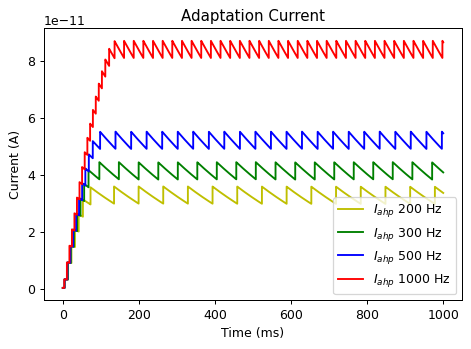

In [32]:
# Confronting
# Time of interest
tstart = 0 # ms 
tend   = 1000 # ms


plot(adapt_200.item().get('t')[tstart*s:tend*s], adapt_200.item().get('Iahp')[tstart*s:tend*s]*pA, linewidth=1.5,color='y',label='$I_{ahp}$ 200 Hz')
plot(adapt_300.item().get('t')[tstart*s:tend*s], adapt_300.item().get('Iahp')[tstart*s:tend*s]*pA, linewidth=1.5,color='g',label='$I_{ahp}$ 300 Hz')
plot(adapt_500.item().get('t')[tstart*s:tend*s], adapt_500.item().get('Iahp')[tstart*s:tend*s]*pA, linewidth=1.5,color='b',label='$I_{ahp}$ 500 Hz')
plot(adapt_1000.item().get('t')[tstart*s:tend*s], adapt_1000.item().get('Iahp')[tstart*s:tend*s]*pA, linewidth=1.5,color='r',label='$I_{ahp}$ 1000 Hz')


plt.title('Adaptation Current')
plt.xlabel('Time (ms)')
plt.ylabel('Current (A)')
plt.legend(loc='best')
plt.show()

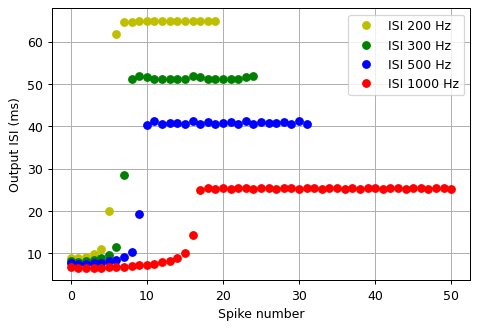

In [33]:
# Plotting output ISI
plot(np.diff(adapt_200.item().get('Output')),'oy',label='ISI 200 Hz')
plot(np.diff(adapt_300.item().get('Output')),'og',label='ISI 300 Hz')
plot(np.diff(adapt_500.item().get('Output')),'ob',label='ISI 500 Hz')
plot(np.diff(adapt_1000.item().get('Output')),'or',label='ISI 1000 Hz')
plt.ylabel('Output ISI (ms)')
plt.xlabel('Spike number')
plt.legend()
plt.grid(True)
plt.show()

Text(0.5, 0, 'Time (ms)')

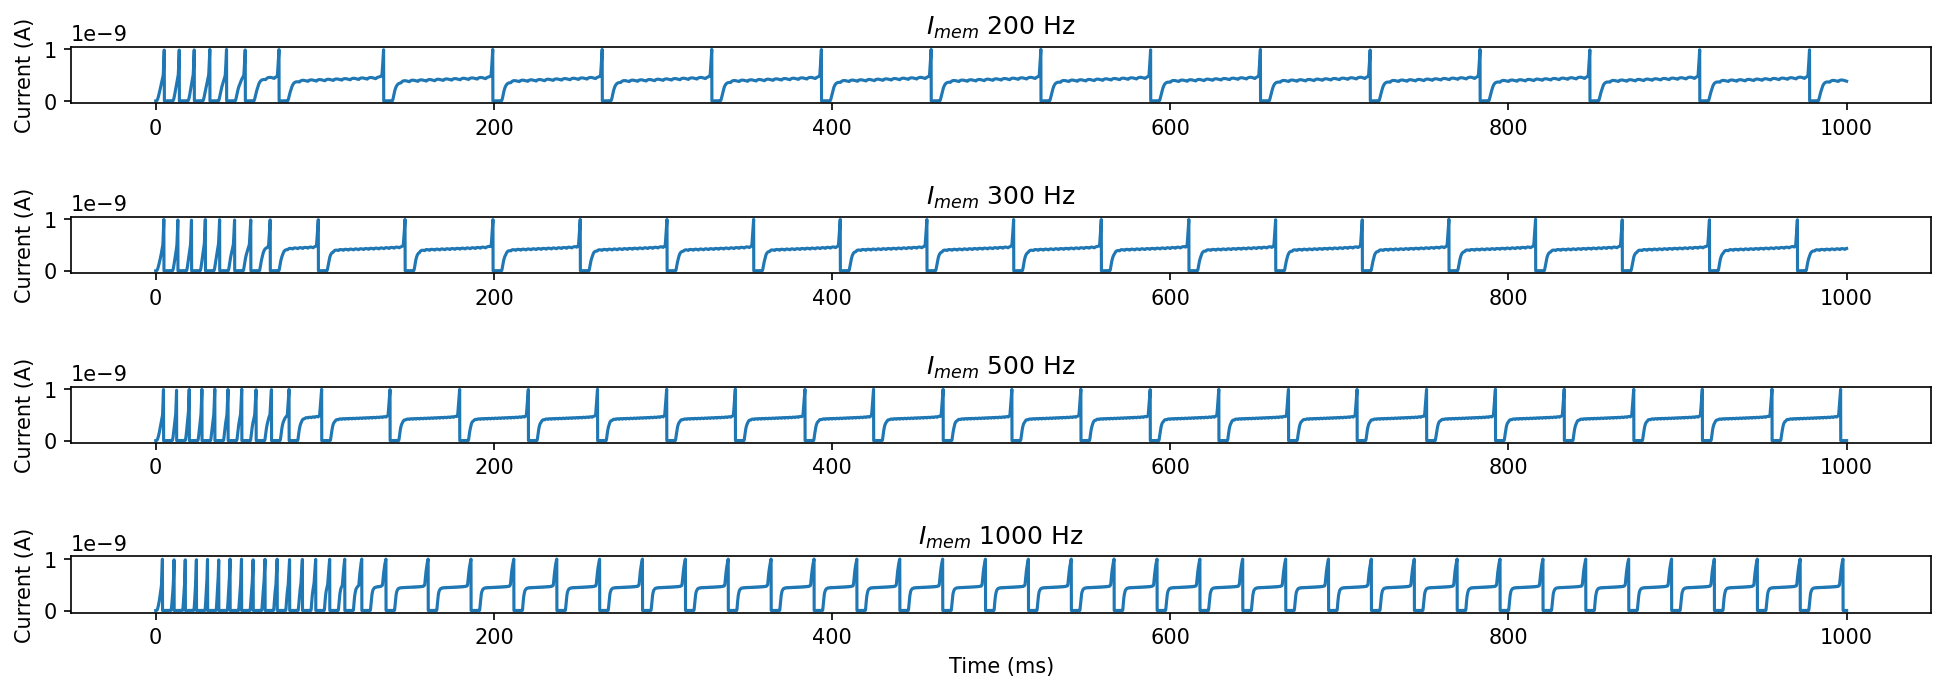

In [26]:
# plotting
plt.figure(figsize=(16,5),dpi=150)
plt.subplots_adjust(hspace=2)




plt.subplot(4,1,1)

plot(adapt_200.item().get('t'), adapt_200.item().get('Imem')*pA, linewidth=1.5,label='$I_{mem}$ 200 Hz')
plt.title('$I_{mem}$ 200 Hz')
plt.ylabel('Current (A)')
#plt.legend(loc='upper right')

plt.subplot(4,1,2)

plot(adapt_300.item().get('t'), adapt_300.item().get('Imem')*pA, linewidth=1.5,label='$I_{mem}$ 300 Hz')
plt.title('$I_{mem}$ 300 Hz')
plt.ylabel('Current (A)')
#plt.legend(loc='upper right')

plt.subplot(4,1,3)
plot(adapt_500.item().get('t'), adapt_500.item().get('Imem')*pA, linewidth=1.5,label='$I_{mem}$ 500 Hz')
plt.title('$I_{mem}$ 500 Hz')
plt.ylabel('Current (A)')
#plt.legend(loc='upper right')

plt.subplot(4,1,4)
plot(adapt_1000.item().get('t'), adapt_1000.item().get('Imem')*pA, linewidth=1.5,label='$I_{mem}$ 1000 Hz')
plt.title('$I_{mem}$ 1000 Hz')
plt.ylabel('Current (A)')
#plt.legend(loc='upper right')
plt.xlabel('Time (ms)')




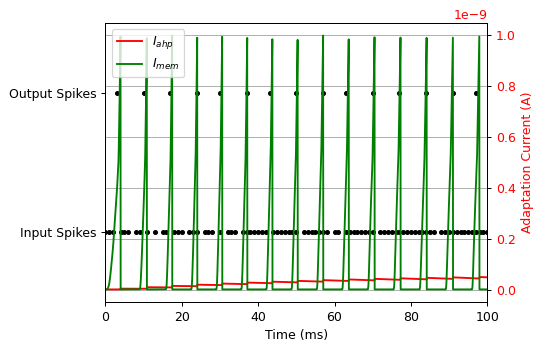

In [34]:
##################
#  TODO: Change tstart and tend to find the time window that shows spike-frequency adaptation.
#
# Parameters
tstart = 0 # ms - 
tend   = 100 # ms -
##################


# Plotting
spike_placeholder = np.zeros(inp_duration*1000)
spike_placeholder[np.array(mon_neuron_input.t/ms, dtype=int)]=2

spike_placeholder2 = np.zeros(inp_duration*1000)
spike_placeholder2[np.array(mon_neuron_output.t/ms, dtype=int)]=3

s = int(1*ms / defaultclock.dt)
fig, ax1 = plt.subplots()

ax1.set_xlabel('Time (ms)')
ax1.plot(spike_placeholder,'k.')
plt.yticks(np.arange(1, 5), ['a','Input Spikes','Output Spikes','d'])
ax1.tick_params(axis='y')
plt.ylim(1.5, 3.5)
plt.xlim(tstart,tend)
ax2 = ax1.twinx()  
ax1.plot(spike_placeholder2,'k.')

ax2.set_ylabel('Adaptation Current (A)', color='r')  
ax2.plot(mon_adapt_state.t/ms, mon_adapt_state.Iahp[0], linewidth=1.5,color='r', label='$I_{ahp}$')
ax2.tick_params(axis='y', labelcolor='r')
plt.xlim(tstart,tend)


fig.tight_layout()
plt.grid(True)

ax2.plot(mon_mem_state.t/ms, mon_mem_state.Imem[0], linewidth=1.5, color='g',label='$I_{mem}$')
plt.legend(loc='best')
plt.show()

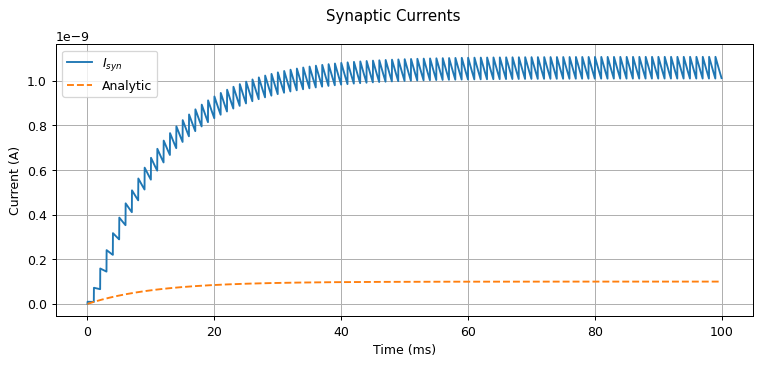

In [35]:
##################
#  TODO: Play with tstart and tend to locate synaptic currents. Try to estimate the time constant of the decay. 
#  Why do you think the amount of current at each input spike are not exactly same?
#
# Parameters
tstart = 0 # ms 
tend   = 100 # ms
##################

# Plotting
fig, ax1 = plt.subplots(figsize=(10,4))
fig.suptitle('Synaptic Currents')
s = int(1*ms / defaultclock.dt)

ax1.plot(mon_mem_state.t[tstart*s:tend*s]/ms, mon_synapse_ampa.I_syn_ampa[0][tstart*s:tend*s], linewidth=1.5, label='$I_{syn}$')
ax1.plot(mon_mem_state.t[tstart*s:tend*s]/ms, DPI_synapse.Iampamax*(1-exp(-mon_mem_state.t/DPI_synapse.tau_syn_exc2[0]))[tstart*s:tend*s], 'C1--',label='Analytic')
ax1.legend()
ax1.set_ylabel('Current (A)')
ax1.set_xlabel('Time (ms)')
ax1.grid(True)


In [36]:
print('Input firing rate = ', mon_neuron_input.count/ (inp_duration* 1000 * ms))
print('Output firing rate = ', mon_neuron_output.count/ (inp_duration* 1000 * ms))
print('number of input spikes',mon_neuron_input.count[0])
print('number of output spikes',mon_neuron_output.count[0])
print('maximum value of Isyn',DPI_synapse.Iampamax[0])
print('steady state value of Isyn',DPI_synapse.I_syn_ampa[0])
print('The maximum adaptation current is', DPI_neuron.Iahpmax[0])
print('steady state value of Iahp',DPI_neuron.Iahp[0])
print('time constant of Iahp', DPI_neuron.tauahp[0])
print('time constant of Isyn', DPI_synapse.tau_syn_exc2[0])
print('time constant of Imem', DPI_neuron.tau[0])

Input firing rate =  [1.] kHz
Output firing rate =  [138.] Hz
number of input spikes 1000
number of output spikes 138
maximum value of Isyn 100. pA
steady state value of Isyn 1.01051319 nA
The maximum adaptation current is 6. pA
steady state value of Iahp 56.02002827 pA
time constant of Iahp 70.92198582 ms
time constant of Isyn 10.63829787 ms
time constant of Imem 53.19148936 ms


Text(0.5, 0, 'Time (ms)')

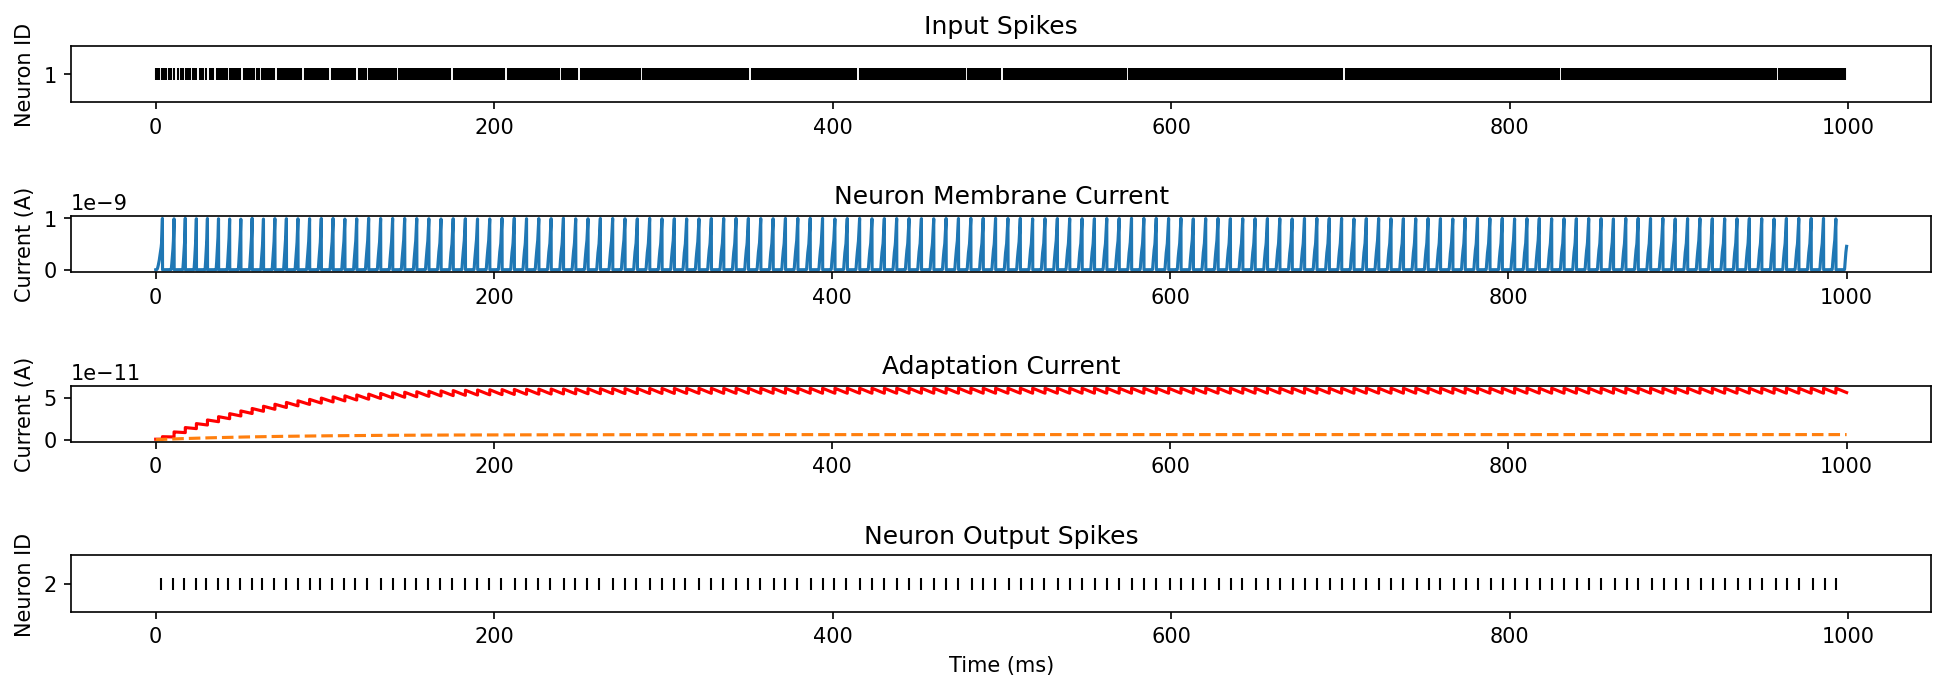

In [37]:
# plotting
plt.figure(figsize=(16,5),dpi=150)
plt.subplots_adjust(hspace=2)

times = int(inp_duration/ms)

# Input Spikes 
plt.subplot(4,1,1)
spike_placeholder = np.zeros(times)
spike_placeholder[np.array(mon_neuron_input.t/ms, dtype=int)]=1
plt.plot(spike_placeholder,'k|')
matplotlib.pyplot.yticks(range(1, 3))
plt.ylim(0.5, 1.5)
plt.title('Input Spikes')
plt.ylabel('Neuron ID')
#plt.xlabel('Time (ms)')

plt.subplot(4,1,2)
Imem = mon_mem_state.Imem[0]
plt.plot(mon_mem_state.t/ms, Imem)

plt.title('Neuron Membrane Current')
plt.ylabel('Current (A)')
#plt.xlabel('Time (ms)')

plt.subplot(4,1,3)1on.tauahp)), 'C1--',label='Analytic')
plt.title('Adaptation Current')
plt.ylabel('Current (A)')


plt.subplot(4,1,4)
spike_placeholder = np.zeros(times)
spike_placeholder[np.array(mon_neuron_output.t/ms, dtype=int)]=2
plt.plot(spike_placeholder,'k|')
matplotlib.pyplot.yticks(range(1, 3))
plt.ylim(1.5, 2.5)
plt.title('Neuron Output Spikes')
plt.ylabel('Neuron ID')
plt.xlabel('Time (ms)')



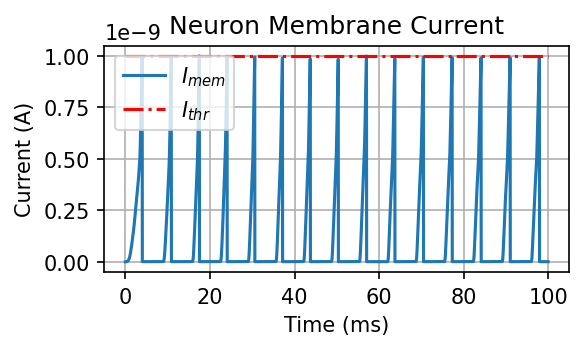

In [38]:
##################
#  TODO: Play with tstart and tend to observe membrane current fluctuations and the moments of spike output.
#        Notice that the membrane current is more smoother than its synaptic input.
#
# Parameters
tstart = 0 # ms  
tend   = 100 # ms 
##################

# Plotting
s = int(1*ms / defaultclock.dt)
plt.figure(figsize=(4,2),dpi=150)
plt.plot(mon_mem_state.t[tstart*s:tend*s]/ms, mon_mem_state.Imem[0][tstart*s:tend*s], linewidth=1.5)
plt.hlines(y=dynapse_param['Ispkthr']*1e-9/nA, xmin=tstart, xmax=tend, color='r', linestyles='-.')
plt.legend(['$I_{mem}$', '$I_{thr}$'])
plt.title('Neuron Membrane Current')
plt.ylabel('Current (A)')
plt.xlabel('Time (ms)')
plt.grid(True)

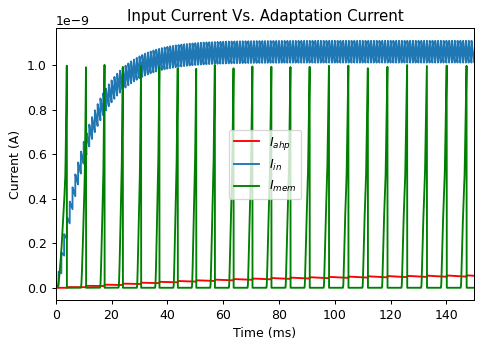

In [39]:
# Time of interest
tstart = 0 # ms 
tend   = 150 # ms

Iahp_theor = DPI_neuron.Iahpmax*(1-exp(-mon_adapt_state.t/DPI_neuron.tauahp))
Iin_theor = DPI_synapse.Iampamax*(1-exp(-mon_mem_state.t/DPI_synapse.tau_syn_exc2[0]))

plot(mon_adapt_state.t[tstart*s:tend*s]/ms, mon_adapt_state.Iahp[0][tstart*s:tend*s], linewidth=1.5,color='r', label='$I_{ahp}$')
plot(mon_mem_state.t[tstart*s:tend*s]/ms, mon_synapse_ampa.I_syn_ampa[0][tstart*s:tend*s], linewidth=1.5, label='$I_{in}$')
plot(mon_mem_state.t/ms, mon_mem_state.Imem[0], linewidth=1.5, color='g',label='$I_{mem}$')
plt.title('Input Current Vs. Adaptation Current')
plt.xlabel('Time (ms)')
plt.ylabel('Current (A)')
plt.xlim(tstart,tend)
plt.legend(loc='best')
plt.show()

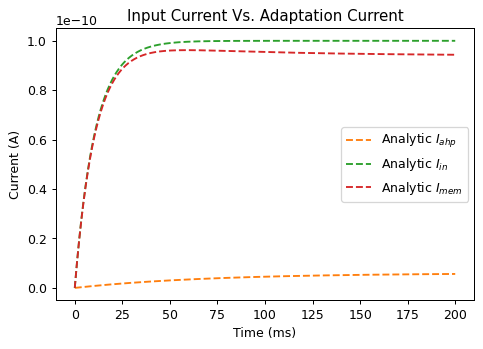

In [40]:
# Time of interest
tstart = 0 # ms 
tend   = 200 # ms

Iahp_theor = DPI_neuron.Iahpmax*(1-exp(-mon_adapt_state.t/DPI_neuron.tauahp))
Iin_theor = DPI_synapse.Iampamax*(1-exp(-mon_mem_state.t/DPI_synapse.tau_syn_exc2[0]))
diff_theor = Iin_theor - Iahp_theor

plot(mon_adapt_state.t[tstart*s:tend*s]/ms, Iahp_theor[tstart*s:tend*s], 'C1--',label='Analytic $I_{ahp}$')
plot(mon_mem_state.t[tstart*s:tend*s]/ms, Iin_theor[tstart*s:tend*s], 'C2--',label='Analytic $I_{in}$')
plot(mon_mem_state.t[tstart*s:tend*s]/ms, diff_theor[tstart*s:tend*s], 'C3--',label='Analytic $I_{mem}$')

plt.title('Input Current Vs. Adaptation Current')
plt.xlabel('Time (ms)')
plt.ylabel('Current (A)')
plt.legend(loc='best')
plt.show()

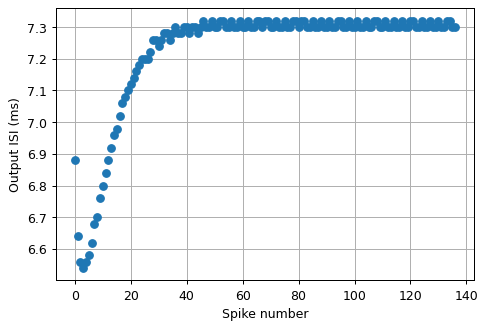

In [41]:
# Plotting output ISI
plot(np.diff(mon_neuron_output.t/ms),'o')
plt.ylabel('Output ISI (ms)')
plt.xlabel('Spike number')
plt.grid(True)